## Import Libraries

In [1]:
import re
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences

import warnings
warnings.filterwarnings("ignore")

## Read Data

In [2]:
headers = ["Sentiment", "Text"]

train_neg = pd.read_csv(r"data/train_Arabic_tweets_negative_20190413.tsv", sep="\t", names=headers, header=None)
train_pos = pd.read_csv(r"data/train_Arabic_tweets_positive_20190413.tsv", sep="\t", names=headers, header=None)

test_neg  = pd.read_csv(r"data/test_Arabic_tweets_negative_20190413.tsv", sep="\t", names=headers, header=None)
test_pos  = pd.read_csv(r"data/test_Arabic_tweets_positive_20190413.tsv", sep="\t", names=headers, header=None)

## Data Preprocessing

In [3]:
# Combine the datasets
data = pd.concat([train_neg, train_pos, test_neg, test_pos], axis=0).reset_index(drop=True)

# Shuffle the datasets
data = data.sample(frac=1).reset_index(drop=True)

In [4]:
# Remove duplicates
data.drop_duplicates(inplace=True)

# Remove null values
data.dropna(subset=['Text'], inplace=True)

In [5]:
# Verify class distribution
print("Class distribution in training set:")
print(data['Sentiment'].value_counts())

Class distribution in training set:
Sentiment
neg    18410
pos    17466
Name: count, dtype: int64


In [6]:
# Ensure at least two classes are present
if len(data['Sentiment'].unique()) < 2:
    raise ValueError("The training dataset must contain at least two classes.")

In [7]:
# Arabic text normalization
def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)  # Normalize Alif
    text = re.sub("ى", "ي", text)   # Normalize Ya
    text = re.sub("ؤ", "ء", text)   # Normalize Hamza
    text = re.sub("ئ", "ء", text)  # Normalize Hamza
    text = re.sub("ة", "ه", text)  # Normalize Ta Marbuta
    return text

# Remove Tashkeel (diacritics)
def remove_tashkeel(text):
    text = re.sub(r'[\u0617-\u061A\u064B-\u0652]', '', text)
    return text

# Remove repeated characters
def remove_repeated_chars(text):
    text = re.sub(r'(.)\1+', r'\1', text)
    return text

# Remove non-Arabic characters, links, and hashtags
def clean_text(text):
    text = re.sub(r'http\S+', '', text)    # Remove URLs
    text = re.sub(r'@\S+', '', text)       # Remove mentions
    text = re.sub(r'#\S+', '', text)       # Remove hashtags
    text = re.sub(r'[^؀-ۿ ]+', '', text)  # Remove non-Arabic characters
    text = text.strip()                   # Remove leading and trailing whitespace
    return text

# Tokenization and stop words removal
nltk.download('stopwords')
arabic_stopwords = set(stopwords.words("arabic"))

def preprocess_text(text):
    text = normalize_arabic(text)
    text = remove_tashkeel(text)
    text = remove_repeated_chars(text)
    # text = clean_text(text)
    text = ' '.join([word for word in text.split() if word not in arabic_stopwords])
    return text

# Apply preprocessing
data['Text'] = data['Text'].apply(preprocess_text)

# Convert Sentiment labels to binary (0: Negative, 1: Positive)
data['Sentiment'] = data['Sentiment'].apply(lambda x: 0 if x == 'neg' else 1)

print("Text preprocessing complete.")

[nltk_data] Downloading package stopwords to C:\Users\Mohamed
[nltk_data]     Abdalkader\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Text preprocessing complete.


## Data Visualization

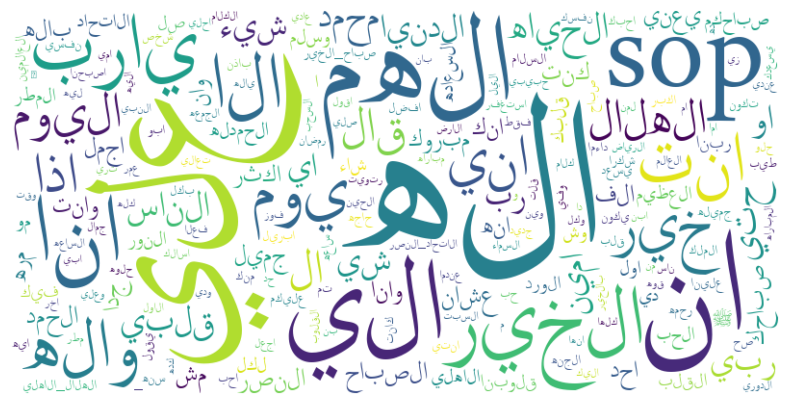

In [8]:
# Combine all positive tweets into one string
all_tweets = " ".join(data[data["Sentiment"] == 1]['Text'].astype(str).tolist())

# Reverse the text to handle right-to-left languages (Arabic)
def reverse_text(text):
    return text[::-1]

# Apply the text reversal
all_tweets_reversed = reverse_text(all_tweets)

# Path to the Arabic font
arabic_font_path = r'C:\Windows\Fonts\arabtype.ttf'

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', 
                      font_path=arabic_font_path, collocations=False).generate(all_tweets_reversed)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off the axis
plt.show()

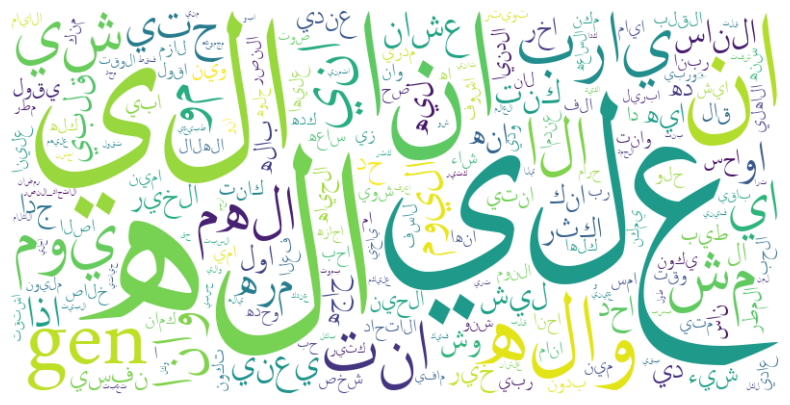

In [9]:
# Combine all negative tweets into one string
all_tweets = " ".join(data[data["Sentiment"] == 0]['Text'].astype(str).tolist())

# Reverse the text to handle right-to-left languages (Arabic)
def reverse_text(text):
    return text[::-1]

# Apply the text reversal
all_tweets_reversed = reverse_text(all_tweets)

# Path to the Arabic font
arabic_font_path = r'C:\Windows\Fonts\arabtype.ttf'

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', 
                      font_path=arabic_font_path, collocations=False).generate(all_tweets_reversed)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off the axis
plt.show()

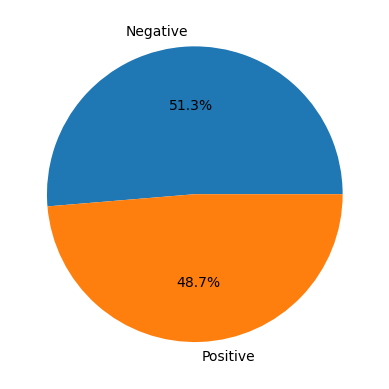

In [10]:
value_counts = data["Sentiment"].value_counts()
plt.pie(value_counts, labels=["Negative", "Positive"], autopct='%1.1f%%')
plt.show()

In [11]:
# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(data['Text'], data['Sentiment'], test_size=0.2, random_state=42)

## Modeling

### Machine Learning (Traditional Models)

In [12]:
# Define the pipeline for machine learning
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),  # Convert text to TF-IDF features
    ('clf', LogisticRegression())  # Classifier
])

# Training the model
pipeline.fit(X_train, y_train)

# Predicting on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
print("Machine Learning Model Evaluation")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred))

Machine Learning Model Evaluation
Accuracy: 0.6611
              precision    recall  f1-score   support

           0       0.65      0.74      0.69      3652
           1       0.68      0.58      0.63      3524

    accuracy                           0.66      7176
   macro avg       0.66      0.66      0.66      7176
weighted avg       0.66      0.66      0.66      7176



### Deep Learning

In [13]:
# Parameters
MAX_NUM_WORDS = 10000  # Vocabulary size
MAX_SEQUENCE_LENGTH = 100  # Maximum sequence length
EMBEDDING_DIM = 100  # Embedding dimensions

# Tokenization and padding
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH)

X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH)

# Encoding labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Build the LSTM model
model = Sequential([
    Embedding(input_dim=MAX_NUM_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    LSTM(100, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_pad, y_train_encoded, epochs=5, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_pad, y_test_encoded)
print("Deep Learning Model Evaluation")
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/5
718/718 ━━━━━━━━━━━━━━━━━━━━ 40s 50ms/step - accuracy: 0.8100 - loss: 0.3910 - val_accuracy: 0.9014 - val_loss: 0.2239
Epoch 2/5
718/718 ━━━━━━━━━━━━━━━━━━━━ 35s 49ms/step - accuracy: 0.9443 - loss: 0.1490 - val_accuracy: 0.9042 - val_loss: 0.2286
Epoch 3/5
718/718 ━━━━━━━━━━━━━━━━━━━━ 36s 50ms/step - accuracy: 0.9599 - loss: 0.1120 - val_accuracy: 0.8958 - val_loss: 0.2760
Epoch 4/5
718/718 ━━━━━━━━━━━━━━━━━━━━ 36s 51ms/step - accuracy: 0.9701 - loss: 0.0847 - val_accuracy: 0.8911 - val_loss: 0.3090
Epoch 5/5
718/718 ━━━━━━━━━━━━━━━━━━━━ 37s 51ms/step - accuracy: 0.9773 - loss: 0.0669 - val_accuracy: 0.8883 - val_loss: 0.3677
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.8890 - loss: 0.3604
Deep Learning Model Evaluation
Test Accuracy: 0.8895


In [14]:
# Predicting on the test set
y_pred_prob = model.predict(X_test_pad)
y_pred = (y_pred_prob > 0.5).astype(int)

# Convert predictions back to original labels
y_pred = y_pred.flatten()
y_test_encoded = np.array(y_test_encoded)

print(classification_report(y_test_encoded, y_pred))

225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step
              precision    recall  f1-score   support

           0       0.88      0.90      0.89      3652
           1       0.90      0.88      0.89      3524

    accuracy                           0.89      7176
   macro avg       0.89      0.89      0.89      7176
weighted avg       0.89      0.89      0.89      7176

